In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import timeit
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import ks_2samp
from preprocess import ts_builder_3d, Connection
from util import *





2023-02-14 00:38:16.423130: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-14 00:38:16.423158: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
c = Connection(verbose=True)

c.clean_clinic_data(miss_rate=0.2, cleaned_version=False, max_gcs=15, ext_subjects=False)
c.clean_vital_data()
c.clean_lab_data()
c.clean_gcs_data()

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (44,83) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (0,1,6,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Column PresSeizuresDuration has been dropped
Column EDAbgFiO2 has been dropped
Column EDAbgBd has been dropped
Column EDAbgBe has been dropped
Column EDAbgBicarbonate has been dropped
Column EDAbgPaO2 has been dropped
Column EDAbgPaCO2 has been dropped
Column EDOsmo has been dropped
Column EDInr has been dropped
Column EDProthrombineTime has been dropped
Column EDLactate has been dropped
Column EDaPtt has been dropped
Column EDAbgPH has been dropped
Column EDDischTemp has been dropped
Column EDDrugScreenAlcohol has been dropped
Column EDDrugScreenAlcoholLess10mgdl has been dropped
Column ConsentWithdrawnTimeSinceInj has been dropped
Column DeathTimeSinceInj has been dropped
Column Rem_Day has been dropped
Column Rem_Time has been dropped
Column DeathCause has been dropped
Column DeathCauseOther has been dropped
Column BrainDonor has been dropped
Column ApptResultMRI6Mo has been dropped
Column GcsEdArrManualScore has been dropped
Column HospDischTimeSinceInj has been dropped
Column ICPM

In [3]:
output_type = 'Binary'
missing_rate = 0.5

values, pat_ind, var_ind = ts_builder_3d(c, max_len=24, masking=False)

# Populating the output
guid = list(pat_ind.keys())
vars = list(var_ind.keys())
dem_df = c.clinic_data[c.clinic_data.Guid.isin(guid)]
outcomes = np.zeros(len(guid))
for row in dem_df.itertuples():
    pind = pat_ind[getattr(row, 'Guid')]
    outcomes[pind] = getattr(row, 'GOSEScore')

# Calculating aggregated values
values_mean = np.nanmean(values, axis=1)
values_max = np.nanmax(values, axis=1)
values_min = np.nanmin(values, axis=1)

# Dropping columns with high missingness
dropped_ind = np.where(np.isnan(values_mean).sum(axis=0)/902 > missing_rate)[0]
values_mean = np.delete(values_mean, dropped_ind, axis=1)
values_max = np.delete(values_max, dropped_ind, axis=1)
values_min = np.delete(values_min, dropped_ind, axis=1)
vars = np.delete(vars, dropped_ind)

# Populating demographic data
dem_cols = ['Sex', 'AgeRecodedPHI']
values_dem = np.array([np.squeeze(dem_df.loc[dem_df.Guid == i,
                                             dem_cols].values.astype('float32'))
                       for i in pat_ind])

# Concatinating columns
# input_values = np.concatenate((values_mean, values_max), axis=1)
input_values = np.concatenate((values_mean, values_dem), axis=1)
input_vars = np.concatenate((vars, dem_cols))
# input_vars = ['AVG_' + i for i in vars]
# input_vars = np.concatenate((input_vars, ['MAX_' + i for i in vars]))
# input_vars = np.concatenate((input_vars, ['MIN_' + i for i in vars]))
input_vars = [ALL_VAR_MAP[x] if x in ALL_VAR_MAP.keys() else x for x in input_vars]
input_vars = [x[6:] if x.startswith('Daily') else x for x in input_vars]
var_ind = inv_list(input_vars)

# Splitting data to test and train
train_x, test_x, train_y, test_y = train_test_split(input_values, outcomes,
                                                        test_size=0.2, random_state=0,
                                                        stratify=outcomes)
# Imputing missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
train_x = imputer.fit_transform(train_x)
test_x = imputer.fit_transform(test_x)

# Normalizing
train_scaler, test_scaler = StandardScaler(), StandardScaler()
train_x = train_scaler.fit_transform(train_x)
test_x = test_scaler.fit_transform(test_x)

# Discretizing the outcome
train_y, num_output = output_builder(train_y, output_type)
test_y, _ = output_builder(test_y, output_type)

# FLIPPING THE OUTPUTS ----->> 0: Favorable, 1: Unfavorable
train_y = 1 - train_y
test_y = 1 - test_y

397871it [00:00, 684608.15it/s]
/tmp/ipykernel_656/579686778.py:16: RuntimeWarning: Mean of empty slice
  values_mean = np.nanmean(values, axis=1)
/tmp/ipykernel_656/579686778.py:17: RuntimeWarning: All-NaN slice encountered
  values_max = np.nanmax(values, axis=1)
/tmp/ipykernel_656/579686778.py:18: RuntimeWarning: All-NaN slice encountered
  values_min = np.nanmin(values, axis=1)


In [18]:
input_vars

['Lab Creatinine',
 'Lab Glucose',
 'Lab Hematocrit',
 'Lab Hemoglobin',
 'Lab Platelet',
 'Lab Potassium',
 'Lab Sodium',
 'Lab Wbc',
 'Vitals DBP',
 'Vitals HR',
 'Respiratory=Intubated',
 'Respiratory=NIPPV',
 'Respiratory=NonItubated',
 'Vitals SBP',
 'Vitals SPO2',
 'Vitals Temperature',
 'GCS Eye=No Response',
 'GCS Eye=To Pain',
 'GCS Eye=To Verbal Command',
 'GCS Eye=Spontaneously',
 'GCS Eye=Untestable',
 'GCS Motor=No Response',
 'GCS Motor=Extension',
 'GCS Motor=Flexion Abnormal',
 'GCS Motor=Flexion Withdrawal',
 'GCS Motor=Localize to Pain',
 'GCS Motor=Obeys Commands',
 'GCS Motor=Untestable',
 'GCS Verbal=No Response',
 'GCS Verbal=Incomprehensible Sounds',
 'GCS Verbal=Inappropriate Words',
 'GCS Verbal=Disoriented & Converses',
 'GCS Verbal=Oriented & Converses',
 'GCS Verbal=Untestable',
 'Pupil Reactivity=Both',
 'Pupil Reactivity=Neither',
 'Pupil Reactivity=One',
 'Pupil Reactivity=Untestable',
 'Sex=Female',
 'Age']

# SVM model with continious variables

In [4]:
from sklearn.svm import SVC
svm_model = SVC(probability=True, class_weight='balanced', C=0.8)
svm_model.fit(train_x, train_y)

SVC(C=0.8, class_weight='balanced', probability=True)

In [5]:
from sklearn.metrics import recall_score, roc_auc_score, precision_score
print(roc_auc_score(test_y, svm_model.predict(test_x)))
print(recall_score(test_y, svm_model.predict(test_x), pos_label=1))
print(precision_score(test_y, svm_model.predict(test_x), pos_label=1))

0.8687003968253968
0.8222222222222222
0.6607142857142857


In [6]:
print(roc_auc_score(train_y, svm_model.predict(train_x)))
print(recall_score(train_y, svm_model.predict(train_x), pos_label=1))
print(precision_score(train_y, svm_model.predict(train_x), pos_label=1))

0.91995742448641
0.9184782608695652
0.7071129707112971


## SHAP

In [7]:
import shap
import warnings

warnings.filterwarnings("ignore")
shap.initjs()

In [ ]:
n_background_list = np.array([5, 10, 30, 50 ,100])
n_test = 500
shap_values_list = np.zeros((len(n_background_list), 2, n_test, train_x.shape[1]))
# ---------------
for i in range(len(n_background_list)):    
    background_x = train_x[:n_background_list[i]]
    forground_x = train_x[n_background_list.max():n_background_list.max() + n_test]
    forground_y = train_y[n_background_list.max():n_background_list.max() + n_test]
    forground_out = svm_model.predict_proba(forground_x)[:,1]
    # ---------------
    explainer = shap.KernelExplainer(svm_model.predict_proba, background_x)
    shap_values_list[i] = explainer.shap_values(forground_x)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [11]:
shap_values_list[0].shape

(2, 500, 40)

In [27]:
shap_values_list[3, 1, 4]

array([ 0.0047743 ,  0.        ,  0.02396316,  0.04154196,  0.01775331,
        0.02438718,  0.02455174,  0.05575533,  0.        , -0.03079497,
        0.11107105,  0.        ,  0.10543953,  0.00934879,  0.        ,
        0.0448647 ,  0.04476535,  0.00965911, -0.01008175,  0.02594055,
        0.        , -0.00444067,  0.        ,  0.        ,  0.        ,
       -0.00717858, -0.01701426,  0.00548294,  0.00291214,  0.12995673,
        0.00145539,  0.00319102, -0.009515  , -0.0126777 ,  0.00654855,
        0.        ,  0.00599199,  0.        , -0.01420414,  0.02634174])

In [28]:
shap_values_list[4, 1, 4]

array([ 0.00826111,  0.        ,  0.02406429,  0.03450794,  0.02003614,
        0.0286285 ,  0.02969832,  0.05261314, -0.00252871, -0.02928989,
        0.10634141,  0.00245293,  0.10269586,  0.00732833,  0.002635  ,
        0.04719191,  0.04210022,  0.01080705, -0.01138833,  0.02101184,
        0.00237195, -0.00759479, -0.00446861,  0.        , -0.0042825 ,
       -0.012412  , -0.01589945,  0.00310216,  0.00888209,  0.13078619,
        0.        ,  0.00209897, -0.00904042, -0.0094374 ,  0.00312349,
        0.00079882,  0.00474173,  0.        , -0.00929234,  0.03537909])

In [33]:
dist_method = 'mean'
fairness_similiraty = np.zeros((len(n_background_list), 3))

for i in range(len(n_background_list)):
    model_metrics = np.zeros((len(input_vars), 3))
    exp_metrics = np.zeros((len(input_vars), 3))
    shap_values = shap_values_list[i]
    for var in input_vars:
        # var = 'age'
        feature_ind = var_ind[var]
        pos_labels = (forground_y==1)
        protected_value = (forground_x[:,feature_ind]>0)

        if dist_method == 'mean':
            # Model_based Fairness metrics -------------------
            model_metrics[feature_ind, 0] = np.abs(forground_out[protected_value].mean() - 
                                                  forground_out[~protected_value].mean())
            model_metrics[feature_ind, 1] = np.abs(forground_out[pos_labels & protected_value].mean() -
                                                  forground_out[pos_labels & ~protected_value].mean())
            model_metrics[feature_ind ,2] = np.abs(forground_out[~pos_labels & protected_value].mean() -
                                                  forground_out[~pos_labels & ~protected_value].mean())
            # Explaination-based fariness metrics ----------------
            exp_metrics[feature_ind, 0] = np.abs(shap_values[1, protected_value, feature_ind].mean() - 
                                                 shap_values[1, ~protected_value, feature_ind].mean())
            exp_metrics[feature_ind, 1] = np.abs(shap_values[1, pos_labels & protected_value, feature_ind].mean() -
                                                 shap_values[1, pos_labels & ~protected_value, feature_ind].mean())
            exp_metrics[feature_ind ,2] = np.abs(shap_values[1, ~pos_labels & protected_value, feature_ind].mean() -
                                                 shap_values[1, ~pos_labels & ~protected_value, feature_ind].mean())
        elif dist_method == 'ks':
            # Model-based Fairness metrics -------------------
            model_metrics[feature_ind, 0] = ks_2samp(forground_out[protected_value],
                                                    forground_out[~protected_value]).statistic
            model_metrics[feature_ind, 1] = ks_2samp(forground_out[pos_labels & protected_value],
                                                    forground_out[pos_labels & ~protected_value]).statistic
            model_metrics[feature_ind ,2] = ks_2samp(forground_out[~pos_labels & protected_value],
                                                    forground_out[~pos_labels & ~protected_value]).statistic

            # Explaination-based fariness metrics ----------------
            exp_metrics[feature_ind, 0] = ks_2samp(shap_values[1, protected_value, feature_ind],
                                                   shap_values[1, ~protected_value, feature_ind]).statistic
            exp_metrics[feature_ind, 1] = ks_2samp(shap_values[1, pos_labels & protected_value, feature_ind],
                                                   shap_values[1, pos_labels & ~protected_value, feature_ind]).statistic
            exp_metrics[feature_ind ,2] = ks_2samp(shap_values[1, ~pos_labels & protected_value, feature_ind],
                                                   shap_values[1, ~pos_labels & ~protected_value, feature_ind]).statistic
            # Adjsuting the metircs
            model_metrics = 1 - model_metrics
            exp_metrics = 1 - exp_metrics
            
    # Normalizing the metrics
    model_metrics = (model_metrics - model_metrics.min(axis=0) + 0.001)/(model_metrics.max(axis=0) - model_metrics.min(axis=0) + 0.001)
    exp_metrics = (exp_metrics - exp_metrics.min(axis=0) + 0.001)/(exp_metrics.max(axis=0) - exp_metrics.min(axis=0) + 0.001)
    
    # Similarity between two fairness methods
    fairness_similiraty[i] = np.linalg.norm(model_metrics - exp_metrics, axis=0)
    

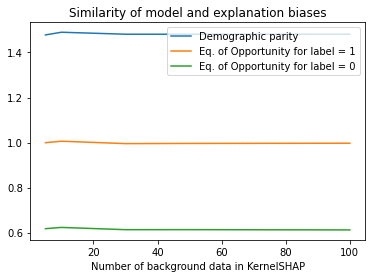

In [28]:
plt.plot(n_background_list, fairness_similiraty, label=['Demographic parity', 'Eq. of Opportunity for label = 1',
                                                        'Eq. of Opportunity for label = 0'])
plt.title('Similarity of model and explanation biases')
plt.xlabel('Number of background data in KernelSHAP')
plt.legend()

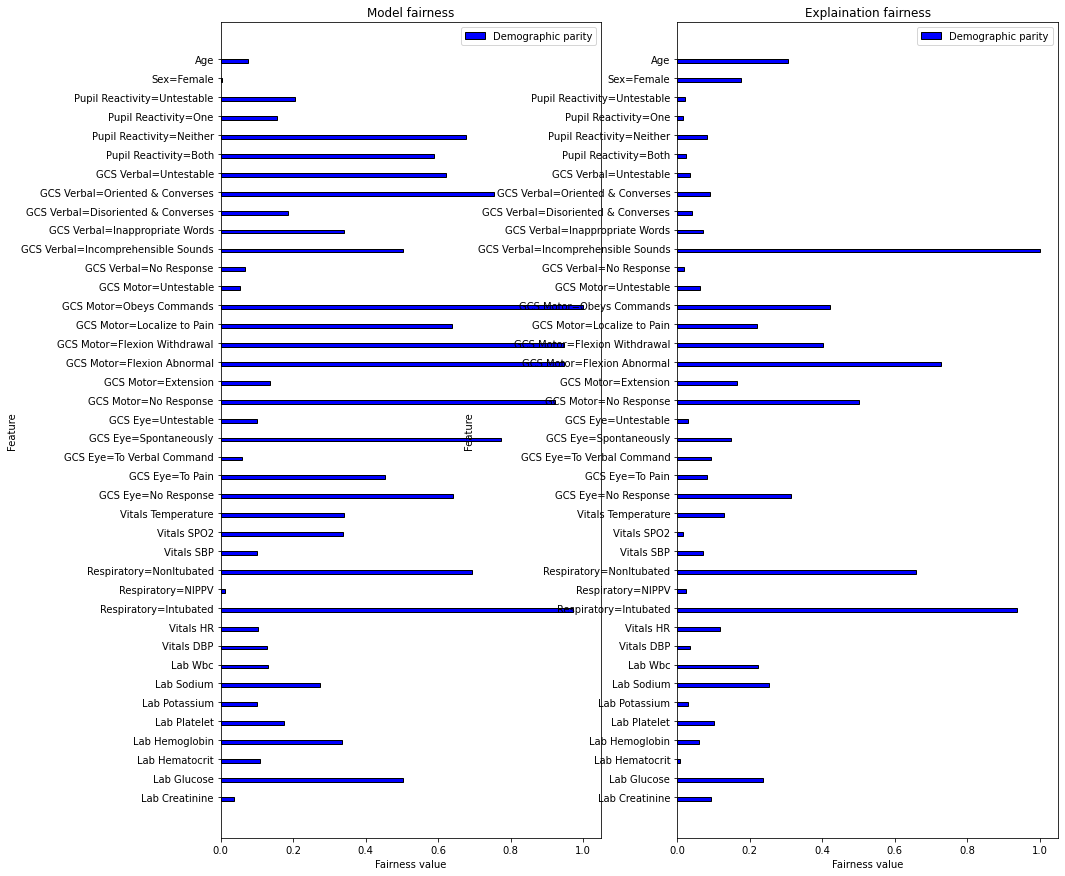

In [36]:
r = np.arange(len(input_vars))
height = 0.20
width = 0.2

fig, ax = plt.subplots(1,2, figsize=(15, 15))

for i, metric in enumerate([model_metrics, exp_metrics]):
    ax[i].barh(r, metric[:, 0], color = 'b', height = height, edgecolor = 'black', label='Demographic parity')
    # ax[i].barh(r + width, metric[:, 1], color = 'g', height = height, edgecolor = 'black',
    #               label='Eq. of Opportunity for label = 1')
    # ax[i].barh(r + 2 * width, metric[:, 2], color = 'r', height = height, edgecolor = 'black',
    #               label='Eq. of Opportunity for label = 0')
    ax[i].set_xlabel("Fairness value")
    ax[i].set_ylabel("Feature")
    ax[i].set_title(['Model fairness', 'Explaination fairness'][i])
    ax[i].set_yticks(r + width/2)
    ax[i].set_yticklabels(input_vars)
    ax[i].legend()

plt.savefig('exp_fair_track1.png')
plt.show()

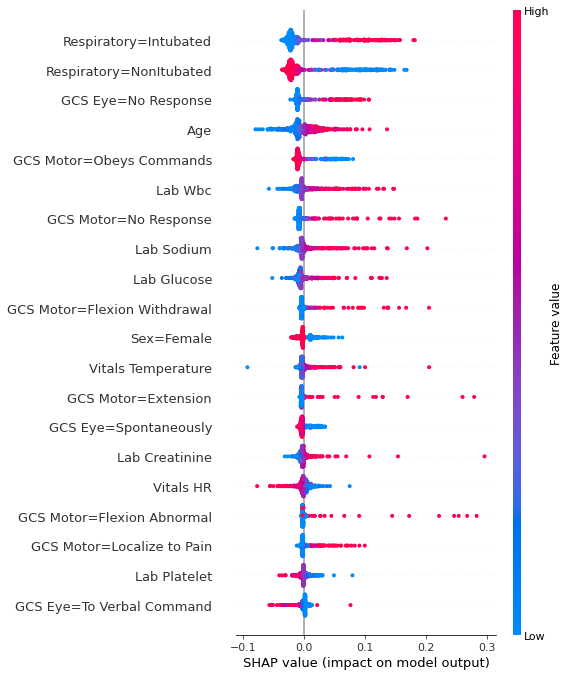

In [21]:
shap.summary_plot(shap_values=shap_values_list[4][1], feature_names=input_vars ,features=forground_x)

In [57]:
shap_values.shape

(2, 500, 40)

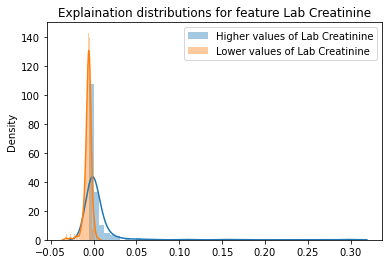

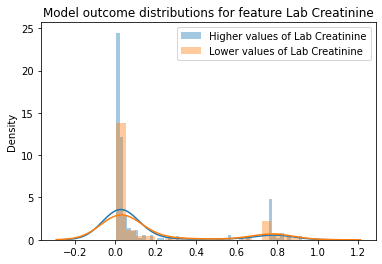

In [41]:
var = 'Lab Creatinine'
feature_ind = var_ind[var]
pos_labels = (forground_y==1)
protected_value = (forground_x[:,feature_ind]>0)
sns.distplot(shap_values[1, protected_value, feature_ind], label='Higher values of {}'.format(var))
sns.distplot(shap_values[1, ~protected_value, feature_ind], label='Lower values of {}'.format(var))
plt.legend()
plt.title('Explaination distributions for feature {}'.format(var))
plt.show()

sns.distplot(forground_out[protected_value], label='Higher values of {}'.format(var))
sns.distplot(forground_out[~protected_value], label='Lower values of {}'.format(var))
plt.legend()
plt.title('Model outcome distributions for feature {}'.format(var))
plt.show()

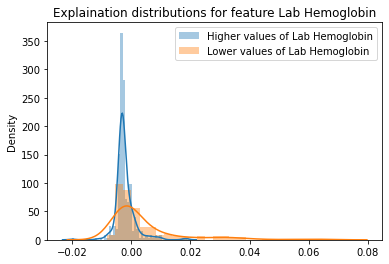

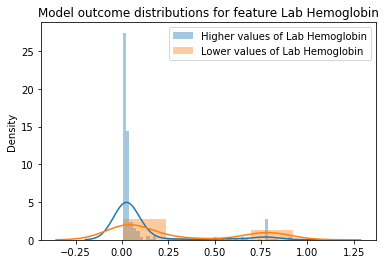

In [40]:
var = 'Lab Hemoglobin'
feature_ind = var_ind[var]
pos_labels = (forground_y==1)
protected_value = (forground_x[:,feature_ind]>0)
sns.distplot(shap_values[1, protected_value, feature_ind], label='Higher values of {}'.format(var))
sns.distplot(shap_values[1, ~protected_value, feature_ind], label='Lower values of {}'.format(var))
plt.legend()
plt.title('Explaination distributions for feature {}'.format(var))
plt.show()

sns.distplot(forground_out[protected_value], label='Higher values of {}'.format(var))
sns.distplot(forground_out[~protected_value], label='Lower values of {}'.format(var))
plt.legend()
plt.title('Model outcome distributions for feature {}'.format(var))
plt.show()

Text(0.5, 1.0, 'Correlation of different features and Sex=Female')

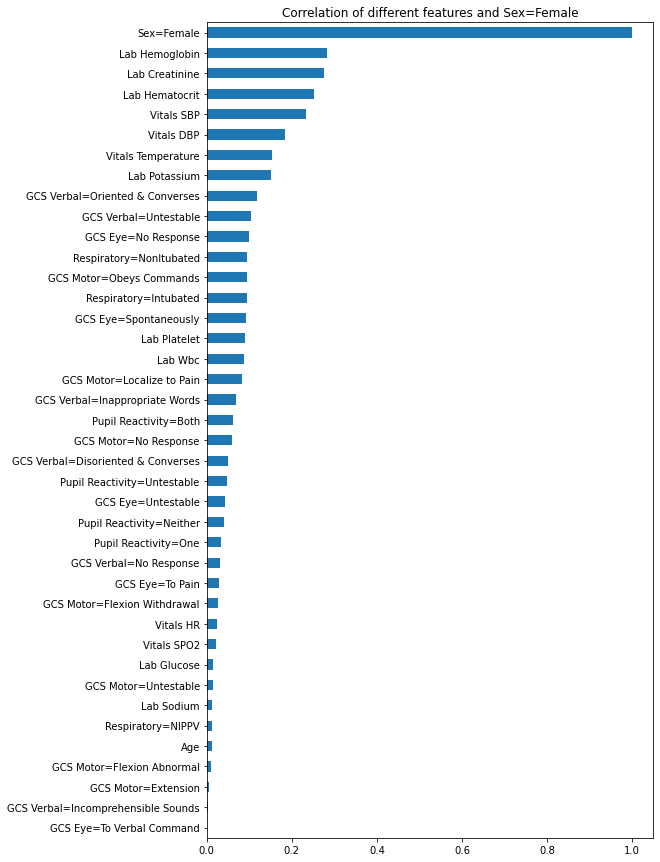

In [38]:
var = 'Sex=Female'
train_x_pd = pd.DataFrame(train_x, columns=input_vars)
train_x_pd.corr()[var].apply(np.abs).sort_values().plot.barh(figsize=(8, 15))
plt.title('Correlation of different features and {}'.format(var))

<AxesSubplot:>

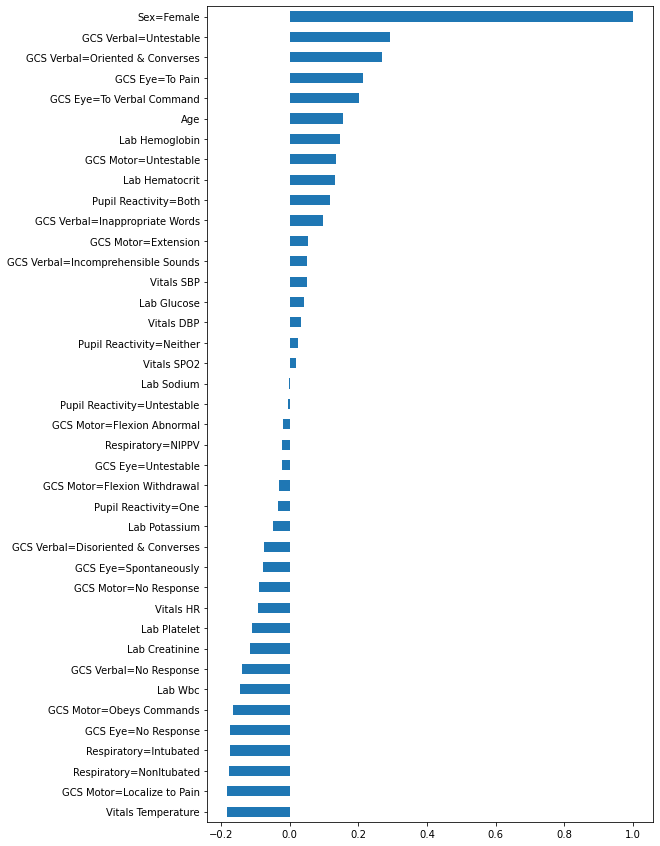

In [23]:
shap_pd = pd.DataFrame(shap_values_list[4][1], columns=input_vars)
shap_pd.corr()['Sex=Female'].sort_values().plot.barh(figsize=(8, 15))